# Practical 1: Unsupervised learning and AI Peer-Programming
Our first lecture introduced us to the different types of machine learning, their use cases, and underlying data structures. Given that the course focuses on supervised learning, we use this introductory practice session and shed, at least, some light on *unsupervised learning*.

Further, we use this notebook to illustrate the capabilities of Generative AI (GenAI). More specifically, we examine how GenAI (e.g., ChatGPT), can help us develop Python codes. To that end, the notebook provides a set of prompts to generate Python codes. Your task is to try out these prompts using an AI of your choice and experiment with the generated programming codes. 

We suggest you begin with the prepared prompts. Afterwards, you are most welcome to make adjustments and examine how changes in your prompts change the generated codes; and by extension the effectiveness of the GenAI support. 

**Disclaimer** Prompts were tested with different versions of ChatGTP and should work reasonably well. That said, there is no guarantee that the provided prompts lead an AI to produce ready-to-use code. As said, one learning goal of this session is to *study how GenAI can help us*. We should not expect it to do all the work.

Let's move on with the first prompt.

## Prompt 1: Cluster analysis
Try out the following prompt using an AI of your choice (e.g., ChatGPT):



#### Copy the generated codes into the below code cell and execute it:

Generated data: 300 samples, 2 features, 3 clusters
Unique predicted cluster labels (before alignment): [0 1 2]
Label mapping (predicted -> true): {np.int64(0): np.int64(0), np.int64(2): np.int64(1), np.int64(1): np.int64(2)}
Clustering accuracy after optimal alignment: 1.0000
Confusion matrix (rows=true labels, cols=predicted labels):
[[100   0   0]
 [  0   0 100]
 [  0 100   0]]


C:\Users\Tamás\AppData\Local\Temp\ipykernel_24592\4051555474.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


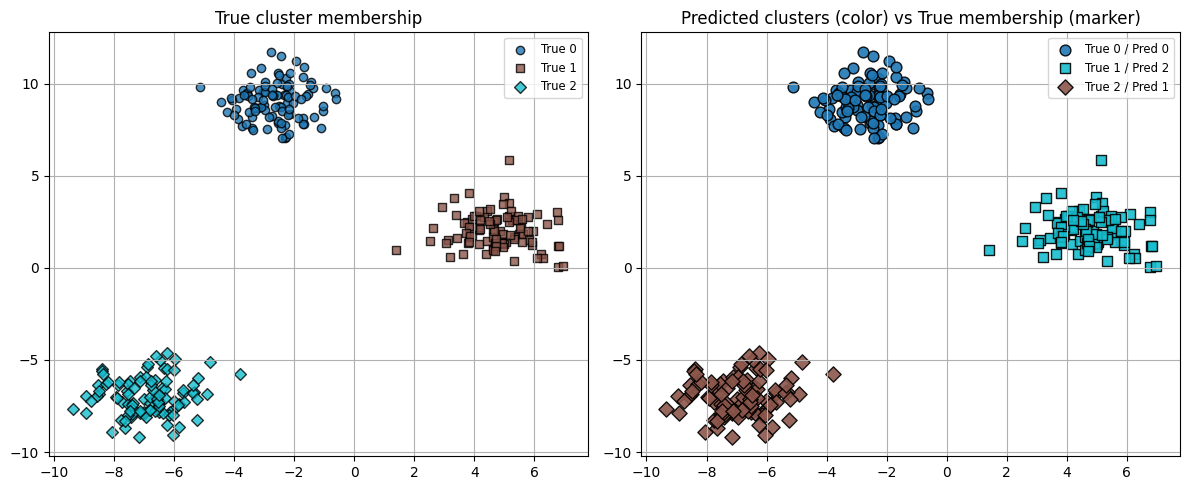

In [3]:
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Generate synthetic 2D data (adjustable difficulty via cluster_std and n_clusters)
def generate_data(n_samples=300, n_clusters=3, cluster_std=1.0, random_state=42):
    X, y_true = make_blobs(n_samples=n_samples,
                           centers=n_clusters,
                           n_features=2,
                           cluster_std=cluster_std,
                           random_state=random_state)
    return X, y_true

# Fit KMeans and return predicted labels
def run_kmeans(X, n_clusters, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    y_pred = kmeans.fit_predict(X)
    return y_pred, kmeans

# Align KMeans labels with true labels using Hungarian algorithm for fair comparison
def align_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # maximize assignment -> use cost = max(cm) - cm
    row_ind, col_ind = linear_sum_assignment(cm.max() - cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    y_pred_aligned = np.vectorize(lambda x: mapping.get(x, x))(y_pred)
    accuracy = (y_pred_aligned == y_true).mean()
    return y_pred_aligned, mapping, accuracy, cm

# Plotting:
# Left: true labels (marker shapes differ by true cluster)
# Right: predicted colors for clusters, marker shapes still encode true cluster membership.
def plot_results(X, y_true, y_pred, y_pred_aligned, n_clusters, save_path=None):
    markers = ['o', 's', 'D', '^', 'v', 'P', 'X', 'h', '*', '+']
    colors = plt.cm.get_cmap('tab10', n_clusters)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # True clusters
    ax = axes[0]
    for label in range(n_clusters):
        idx = y_true == label
        ax.scatter(X[idx, 0], X[idx, 1],
                   marker=markers[label % len(markers)],
                   color=colors(label),
                   edgecolor='k',
                   label=f"True {label}",
                   alpha=0.8)
    ax.set_title("True cluster membership")
    ax.legend(loc='best', fontsize='small')
    ax.grid(True)

    # Predicted clusters: color = predicted cluster, shape = true cluster
    ax = axes[1]
    for t_label in range(n_clusters):
        for p_label in range(n_clusters):
            idx = (y_true == t_label) & (y_pred == p_label)
            if np.any(idx):
                ax.scatter(X[idx, 0], X[idx, 1],
                           marker=markers[t_label % len(markers)],
                           color=colors(p_label),
                           edgecolor='k',
                           label=f"True {t_label} / Pred {p_label}",
                           alpha=0.9,
                           s=60)
    ax.set_title("Predicted clusters (color) vs True membership (marker)")
    # Reduce duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')
    ax.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

def main(args):
    # Generate data with user-specified difficulty
    X, y_true = generate_data(n_samples=args.n_samples,
                              n_clusters=args.n_clusters,
                              cluster_std=args.cluster_std,
                              random_state=args.random_state)

    print(f"Generated data: {X.shape[0]} samples, {X.shape[1]} features, {args.n_clusters} clusters")
    # Visual quick look
    y_pred, kmeans = run_kmeans(X, n_clusters=args.n_clusters, random_state=args.random_state)
    print("Unique predicted cluster labels (before alignment):", np.unique(y_pred))

    y_pred_aligned, mapping, acc, cm = align_labels(y_true, y_pred)
    print("Label mapping (predicted -> true):", mapping)
    print(f"Clustering accuracy after optimal alignment: {acc:.4f}")

    # Show confusion matrix for diagnostics
    print("Confusion matrix (rows=true labels, cols=predicted labels):")
    print(cm)

    plot_results(X, y_true, y_pred, y_pred_aligned, args.n_clusters, save_path=args.save)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Clustering demo (2D synthetic data).")
    parser.add_argument("--n_samples", type=int, default=300, help="Number of samples")
    parser.add_argument("--n_clusters", type=int, default=3, help="Number of clusters to generate and fit")
    parser.add_argument("--cluster_std", type=float, default=1.0,
                        help="Cluster standard deviation (larger -> harder to separate)")
    parser.add_argument("--random_state", type=int, default=42, help="Random seed")
    parser.add_argument("--save", type=str, default=None, help="Optional path to save the figure (png)")
    # When running inside Jupyter, ignore unknown notebook/kernel args
    if 'ipykernel' in sys.modules:
        args, _ = parser.parse_known_args()
    else:
        args = parser.parse_args()
    main(args)

#### Code inspection
As said, the above prompt should work reasonably well, meaning that, at this point, you should have codes for a clustering demo and the corresponding results in front of you.

 The above assumed, note how our prompt explicitly asked for a means to control the difficulty of the clustering task. Review the generated codes and find out how you can achieve this. Adjust the codes to increase the clustering task complexity and rerun them to verify everything worked out as expected. Feel free to repeat this exercise multiple time with various levels of task complexity. This should give you a good understanding of when the clustering algorithm works well and when it fails.

#### Code revision
It is safe to assume that the generated codes were not perfect. Did you spot any issue you think warrants improvement? 
Go back to your AI and try to make it generate better code. You can either revise the prompt or continue the 'discussion' with the AI and ask it to make improvements.  

In case you did not spot any issue, you could feed the generated codes back into the AI and task it to suggest improvements. To do that, you could start your prompt like so:

In [35]:
# Space to copy improved AI-generated codes to demonstrate clustering


## Prompt 2: Dimensionality reduction
Although not stressed in today's lecture, clustering is not the only form of unsupervised learning. Another form involves dimensionality reduction. Receiving a tabular dataset with $m$ columns, a dimensionality reduction algorithm produces a new dataset with $k<<m$ columns (i.e., features) in such a way that the *structur* in the original high-dimensional data is sustained to the largest degree possible.

The goal of dimensionality reduction this approach can be visualization. Reducing a *many-column-table* to only two features facilitates visualizing the data using a scatter plot. 

Popular methods toward dimensionality reduction include Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and UMAP.  

With our second prepared prompt, we try to generate code that demonstrates how to perform dimensionality reduction in Python.

**Suggested prompt:**

In [39]:
# Copy and execute generated code here:



## Programming task:
If the prepared prompt worked as intended, your synthetic high-dimensional data set should comprise `num_clusters` clusters. The 2D projection of the data should also show these clusters. Let's see whether we can also find these clusters in the original, high-dimensional data using a clustering algorithm.

Specifically, drawing on the code generated in response to our first prompt, your task is to write a Python script that clusters your high-dimensional data set. 

Quickly check that *kMeans* really clustered all data points into `num_clusters` clusters by applying the `Numpy` function `unique()` to the *predicted labels* from *kMeans*. For example, your code might look as follows:
```Python
# Code to apply KMeans algorithm to the high-dimensional data set
kmeans = ... # -> for you to complete
predicted_labels = kmeans.fit_predict(data)
print(np.unique(predicted_labels))
```

We suggest you try to solve this task without the help of Gen-AI. 

In [ ]:
# Your solution goes here

**Additional task for the experts:** try to find a way to verify that the algorithm found the correct number of clusters. 
While the above code is enough to solve the task, examining the resulting clustering is suitable is more challenging. 

Since we use synthetic data, an intuitive approach is to compare the true cluster membership (i.e., the variable `labels` that the `make_blobs` function returns) to the output of the `fit_predict` method. Unfortunately, this does not work because of the **arbitrary cluster indexing** in both `make_blobs` and K-means. While `make_blobs` assigns indices to clusters when generating synthetic data, K-means does not know these labels and assigns its own arbitrary indices based on how it organizes clusters during training.

This discrepancy means that even if the clustering is perfectly accurate in terms of data point grouping, the indices of clusters in `make_blobs` and K-means may not align (e.g., what `make_blobs` labels as cluster `0`, K-means might label as cluster `2`). 

To align indices for accurate comparison, we can use the **Hungarian method** to optimally map K-means cluster indices to the true labels, allowing us to objectively assess clustering performance without being affected by differing label assignments.

Using web-search and, if you like, GenAI, try to align the K-means-based cluster indices and those of `make_blobs()`. Afterwards, compute the fraction of correct cluster assignments to assess K-means. 

If you can get this pipeline to work, the next task would be to gradually increase the level of data complexity and to verify that the number of cluster assignment errors increases when the clustering task becomes more difficult.